In [1]:
import networkx as nx
print(nx.__version__)

3.5


--- Setup Complete ---
Loading Zachary's Karate Club graph...
Starting recursive partitioning...
  Iter 1: Split approved. Modularity 0.0000 -> 0.3477
  Iter 2: Split approved. Modularity 0.3477 -> 0.3729
  Iter 3: Split approved. Modularity 0.3729 -> 0.3886
  Iter 4: Split rejected. Modularity would drop. Finalizing community.
  Iter 4: Split rejected. Modularity would drop. Finalizing community.
  Iter 4: Split rejected. Modularity would drop. Finalizing community.
  Iter 4: Split rejected. Modularity would drop. Finalizing community.
...Partitioning complete.

Generating partition visualizations...


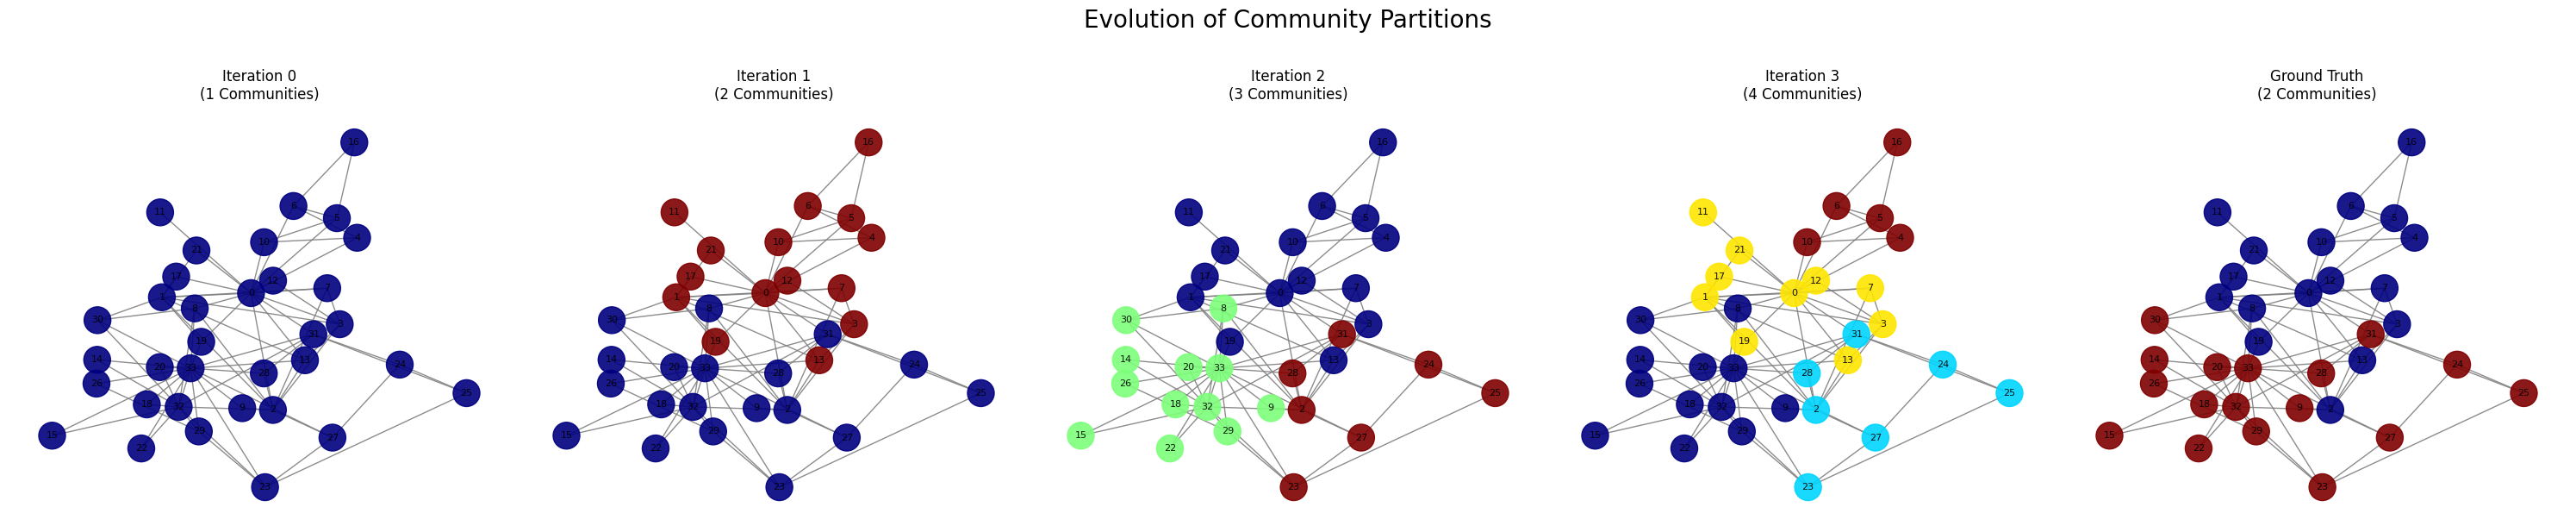

Generating metric evolution plots...


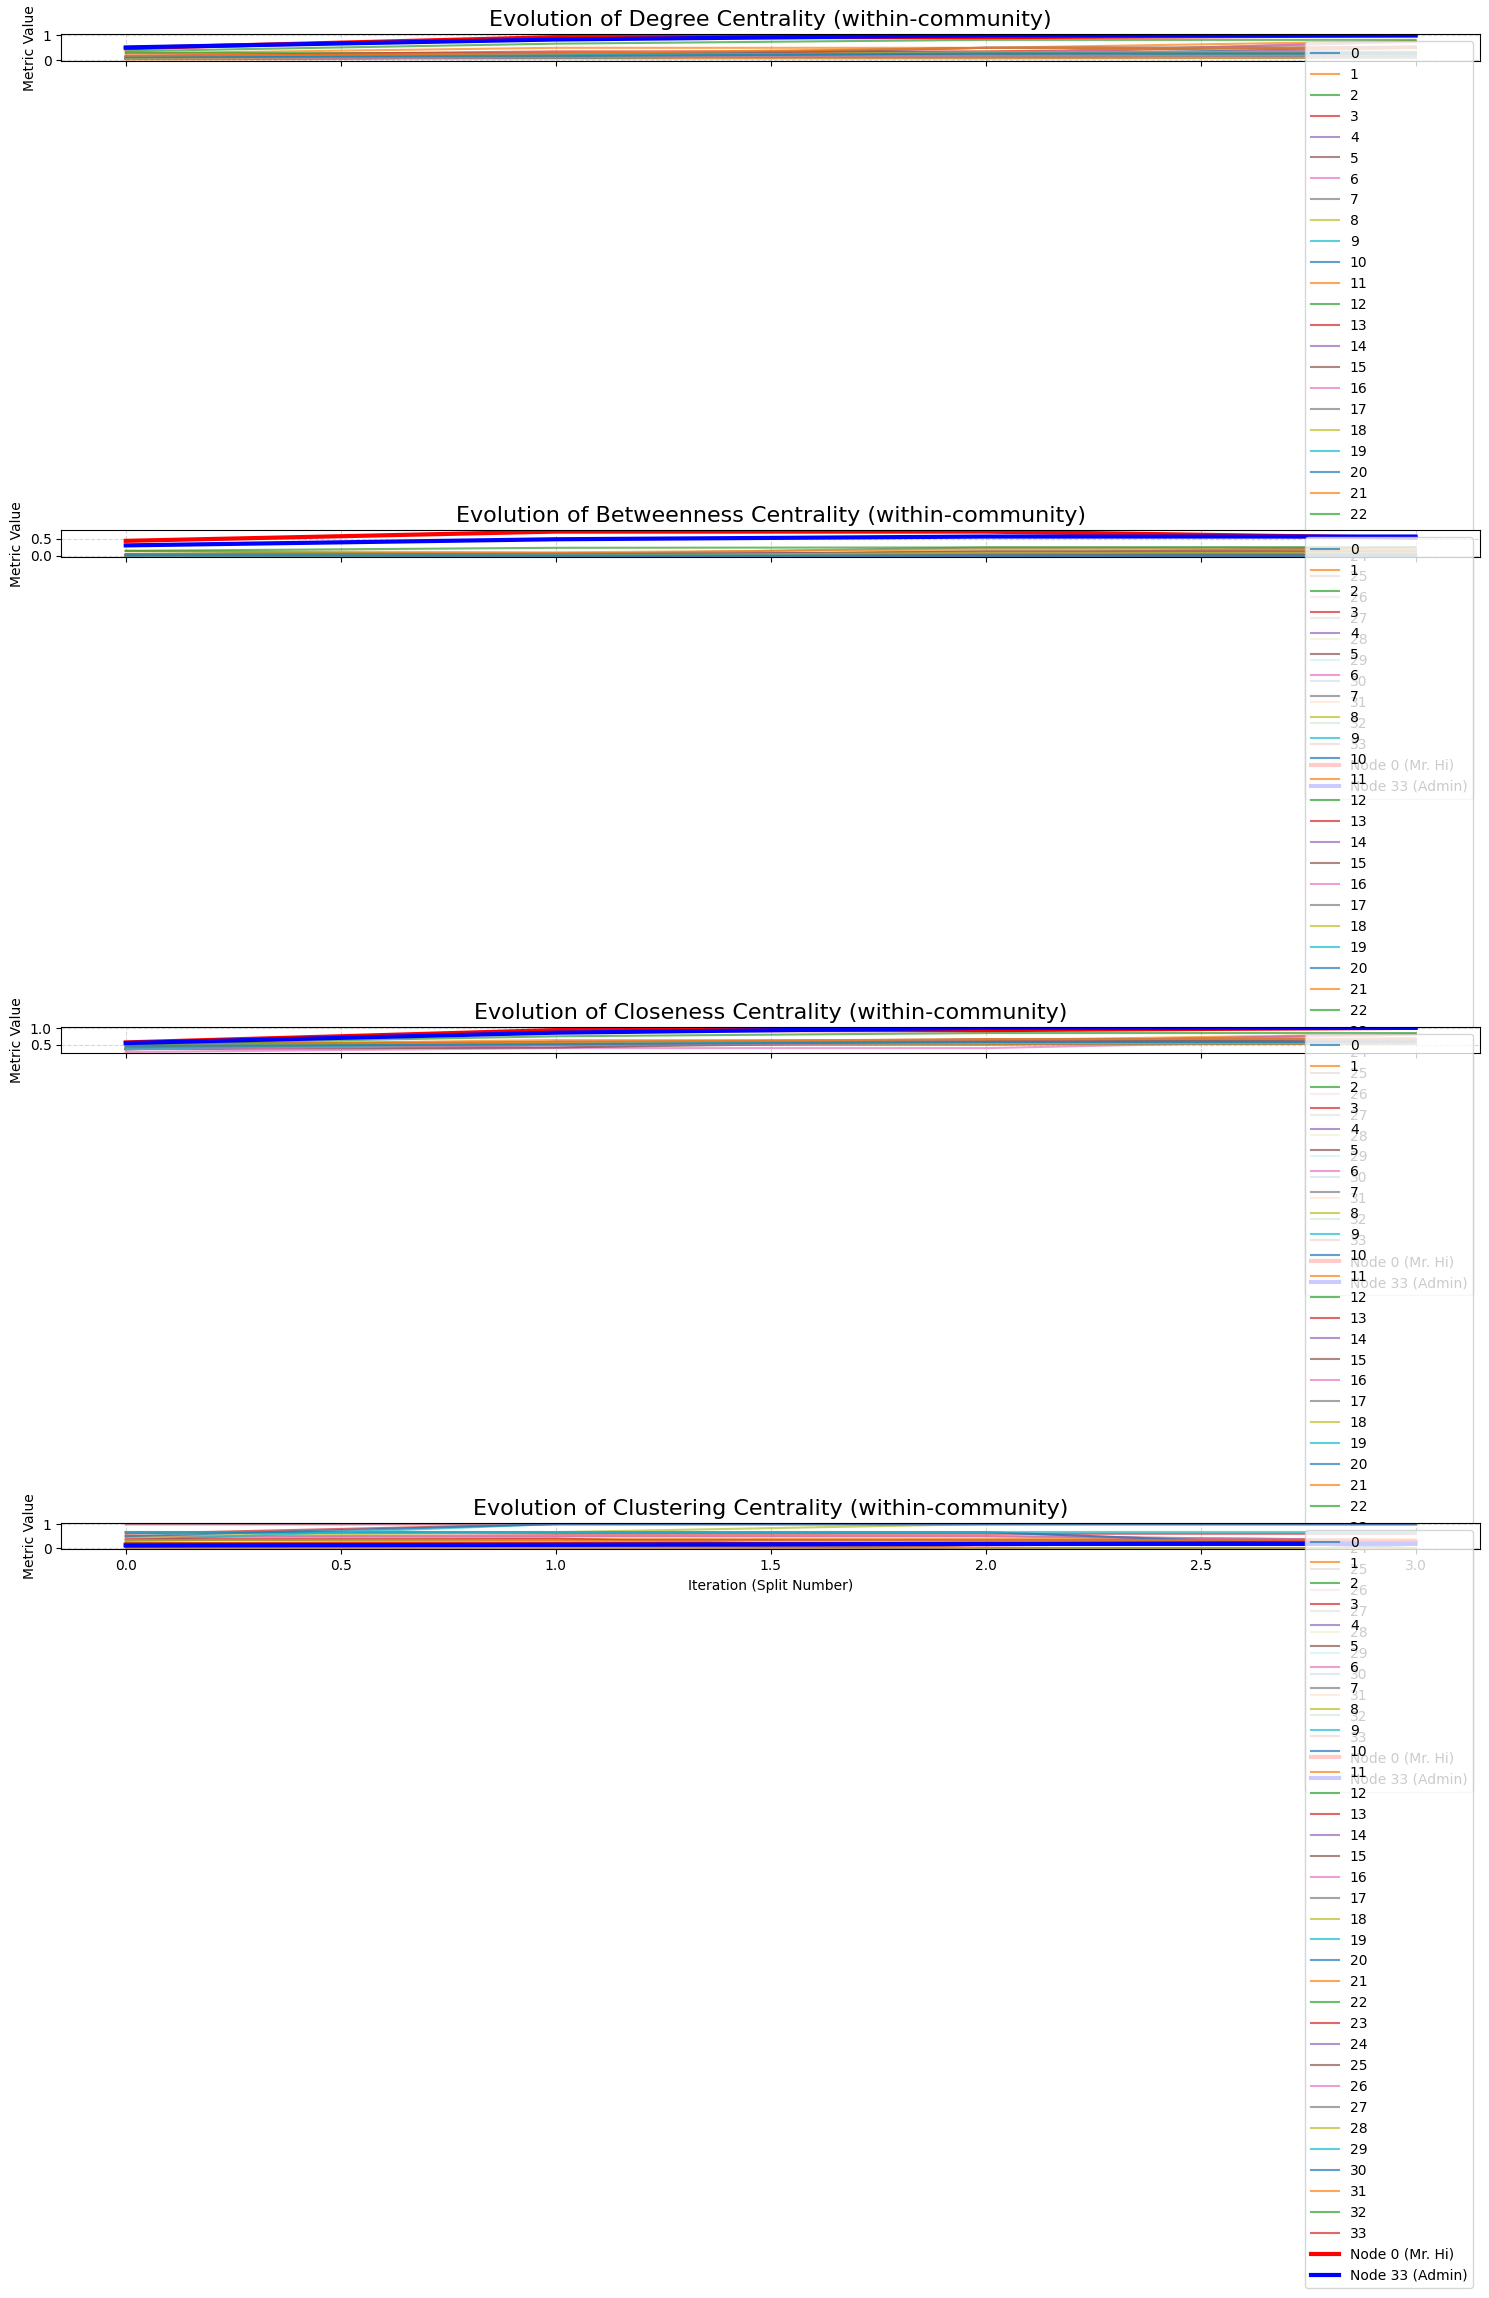


Final Metrics (at final iteration):
      community_id  community_size    degree  betweenness  closeness  \
node                                                                   
33               0              12  1.000000     0.563636   1.000000   
0                2              10  1.000000     0.523148   1.000000   
5                3               5  0.750000     0.250000   0.800000   
6                3               5  0.750000     0.250000   0.800000   
32               0              12  0.818182     0.245455   0.846154   
27               1               7  0.500000     0.244444   0.666667   
31               1               7  0.500000     0.188889   0.666667   
1                2              10  0.777778     0.175926   0.818182   
25               1               7  0.500000     0.133333   0.600000   
24               1               7  0.500000     0.122222   0.666667   
2                1               7  0.333333     0.100000   0.545455   
28               1         

In [4]:
%matplotlib inline
!pip install -q networkx numpy matplotlib pandas
print("--- Setup Complete ---")

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import sys 

def get_fiedler_split(G_sub):
    """ Splits a subgraph into two communities based on the Fiedler vector."""
    if G_sub.number_of_nodes() <= 1:
        return None, None
    L = nx.laplacian_matrix(G_sub, weight=None)
    try:
        eigvals, eigvecs = np.linalg.eigh(L.toarray())
    except np.linalg.LinAlgError:
        return None, None
        
    fiedler_vector = eigvecs[:, 1]
    nodes_array = list(G_sub.nodes())
    comm1 = {nodes_array[i] for i, val in enumerate(fiedler_vector) if val > 0}
    comm2 = {nodes_array[i] for i, val in enumerate(fiedler_vector) if val <= 0}
    if not comm1 or not comm2:
        return None, None
    return comm1, comm2

def calculate_metrics_for_partition(G, partition, iteration):
    metrics_data = []
    for comm_index, community_nodes in enumerate(partition):
        G_sub = G.subgraph(community_nodes)
        try:
            deg_cen = nx.degree_centrality(G_sub)
        except:
            deg_cen = {n: 0 for n in community_nodes}
            
        try:
            bet_cen = nx.betweenness_centrality(G_sub, normalized=True, endpoints=False)
        except:
            bet_cen = {n: 0 for n in community_nodes}

        try:
            clo_cen = nx.closeness_centrality(G_sub)
        except:
            clo_cen = {n: 0 for n in community_nodes}

        try:
            clustering = nx.clustering(G_sub)
        except:
            clustering = {n: 0 for n in community_nodes}
            
        for node in community_nodes:
            metrics_data.append({
                'iteration': iteration,
                'node': node,
                'community_id': comm_index,
                'community_size': len(community_nodes),
                'degree': deg_cen.get(node, 0),
                'betweenness': bet_cen.get(node, 0),
                'closeness': clo_cen.get(node, 0),
                'clustering': clustering.get(node, 0)
            })
    return metrics_data
def plot_partition(G, partition, pos, ax, title):
    """ Draws the graph with nodes coloured by their community"""
    color_map = {}
    for comm_index, community_nodes in enumerate(partition):
        for node in community_nodes:
            color_map[node] = comm_index
    node_colors = [color_map.get(node, -1) for node in G.nodes()]

    nx.draw_networkx(
        G,
        pos=pos,
        ax=ax,
        node_color=node_colors,
        cmap=plt.cm.jet,  # Use a vibrant color map
        node_size=500,
        font_size=8,
        with_labels=True,
        edge_color='gray',
        alpha=0.9
    )
    ax.set_title(title)
    ax.set_axis_off()
def run_recursive_partitioning():
    """ Main function to load the graph and run the algorithm."""
    print("Loading Zachary's Karate Club graph...")
    G = nx.karate_club_graph()
    ground_truth_partition = defaultdict(set)
    for node, data in G.nodes(data=True):
        ground_truth_partition[data['club']].add(node)
    ground_truth_partition = list(ground_truth_partition.values())
    partition_history = []
    metrics_history = []
    partition_queue = [set(G.nodes())]
    final_communities = [] 

    iteration = 0
    
    initial_partition = list(partition_queue)
    partition_history.append(initial_partition)
    metrics_data = calculate_metrics_for_partition(G, initial_partition, iteration)
    metrics_history.append(pd.DataFrame(metrics_data))
    
    print("Starting recursive partitioning...")
    
    while partition_queue:
        community_to_split = partition_queue.pop(0)
        G_sub = G.subgraph(community_to_split)
        comm1, comm2 = get_fiedler_split(G_sub)
        if not comm1 or not comm2:
            final_communities.append(community_to_split)
            continue
        partition_before_split = final_communities + partition_queue + [community_to_split]
        partition_after_split = final_communities + partition_queue + [comm1, comm2]
    
        modularity_before = nx.community.modularity(G, partition_before_split)
        modularity_after = nx.community.modularity(G, partition_after_split)
        if modularity_after > modularity_before:
            # GOOD SPLIT: Accept the split
            print(f"  Iter {iteration+1}: Split approved. Modularity {modularity_before:.4f} -> {modularity_after:.4f}")
            
            partition_queue.append(comm1)
            partition_queue.append(comm2)
        
            iteration += 1
            current_full_partition = final_communities + partition_queue
            
            partition_history.append(current_full_partition)
            metrics_data = calculate_metrics_for_partition(G, current_full_partition, iteration)
            metrics_history.append(pd.DataFrame(metrics_data))
        else:
            # BAD SPLIT: Reject the split
            print(f"  Iter {iteration+1}: Split rejected. Modularity would drop. Finalizing community.")
            final_communities.append(community_to_split)
            
    print("...Partitioning complete.")
    all_metrics_df = pd.concat(metrics_history).set_index(['iteration', 'node']).sort_index()

    return G, partition_history, all_metrics_df, ground_truth_partition

if __name__ == "__main__":
    G, partition_history, metrics_df, ground_truth = run_recursive_partitioning()
    pos = nx.kamada_kawai_layout(G)
    print("\nGenerating partition visualizations...")
    num_iterations = len(partition_history)

    fig, axes = plt.subplots(1, num_iterations + 1, figsize=(6 * (num_iterations + 1), 6))

    for i, partition in enumerate(partition_history):
        plot_title = f"Iteration {i}\n({len(partition)} Communities)"
        plot_partition(G, partition, pos, axes[i], plot_title)
    plot_partition(G, ground_truth, pos, axes[-1], "Ground Truth\n(2 Communities)")

    plt.suptitle("Evolution of Community Partitions", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.savefig("community_evolution.png", bbox_inches='tight')
    plt.show()
    
    print("Generating metric evolution plots...")
    metrics_to_plot = ['degree', 'betweenness', 'closeness', 'clustering']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(15, 20), sharex=True)
    
    for i, metric in enumerate(metrics_to_plot):
        metric_evol_df = metrics_df[metric].unstack(level='node')
        metric_evol_df.plot(ax=axes[i], legend=False, alpha=0.7)
        if 0 in metric_evol_df.columns:
            metric_evol_df[0].plot(ax=axes[i], color='red', lw=3, label='Node 0 (Mr. Hi)')
        if 33 in metric_evol_df.columns:
            metric_evol_df[33].plot(ax=axes[i], color='blue', lw=3, label='Node 33 (Admin)')
    
        axes[i].set_title(f"Evolution of {metric.title()} Centrality (within-community)", fontsize=16)
        axes[i].set_ylabel("Metric Value")
        axes[i].legend(loc='upper right')
        axes[i].grid(True, linestyle='--', alpha=0.5)

    axes[-1].set_xlabel("Iteration (Split Number)")
    plt.tight_layout()
    plt.savefig("metric_evolution.png", bbox_inches='tight')
    plt.show()

    print("\nFinal Metrics (at final iteration):")
    final_iter = metrics_df.index.get_level_values('iteration').max()
    print(metrics_df.xs(final_iter, level='iteration').sort_values('betweenness', ascending=False))
